# Data Collection and Storage (SQL) Project
## Research on ride sharing patterns

I work for as an analyst for Zuber, a new ride-sharing company that's launching in Chicago. 

My task is to find patterns in the available information. I want to understand passenger preferences and the impact of external factors on rides.

## Open the data file and study the general information. 

### Read the data file and import the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy import stats as st
%matplotlib inline

pd.set_option('display.max_rows', None)

try:
    df_trips = pd.read_csv('project_sql_result_01.csv')
    df_neighborhoods = pd.read_csv('project_sql_result_04.csv')
    df_weather = pd.read_csv('project_sql_result_07.csv')
    
except:
    df_trips = pd.read_csv('/datasets/project_sql_result_01.csv')    
    df_neighborhoods = pd.read_csv('/datasets/project_sql_result_04.csv')
    df_weather = pd.read_csv('/datasets/project_sql_result_07.csv')  

print('Files read successfully')

Files read successfully


### 1. Study the general information:

In [2]:
df_trips.sample(10)

,company_name,trips_amount
57,Metro Group,11
49,5074 - 54002 Ahzmi Inc,16
46,3620 - 52292 David K. Cab Corp.,21
12,Dispatch Taxi Affiliation,3355
47,4615 - 83503 Tyrone Henderson,21
13,Nova Taxi Affiliation Llc,3175
15,Checker Taxi Affiliation,2216
51,4623 - 27290 Jay Kim,15
16,Blue Diamond,2070
48,3623 - 72222 Arrington Enterprises,20


In [3]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [4]:
df_trips.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


In [5]:
df_neighborhoods.sample(10)

,dropoff_location_name,average_trips
42,Garfield Park,65.766667
63,Andersonville,16.866667
58,Englewood,25.433333
28,Wicker Park,182.600000
16,Logan Square,620.333333
32,Douglas,142.900000
29,Albany Park,180.900000
4,O'Hare,2546.900000
77,Archer Heights,8.366667
59,Chatham,23.200000


In [6]:
df_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [7]:
df_neighborhoods.describe()

,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


### Conclusion:

**We opened the file and studied the general information.
There is one thing that we should change before starting the EDA step - changing the 'average_trips' column type to int.**

### 2. Prepare the data:

* **Check for duplicates:**

In [8]:
print('Duplicates in df_trips = {}, \nDuplicates in df_neighborhoods = {}'.format(df_trips.duplicated().sum(), 
                                                                                df_neighborhoods.duplicated().sum()))

Duplicates in df_trips = 0, 
Duplicates in df_neighborhoods = 0


* **Change column data type:**

In [9]:
df_neighborhoods.average_trips = round(df_neighborhoods.average_trips, 0).astype(int)

### 3. Analyze the data:

* **Identifying the top 10 neighborhoods in terms of drop-offs:**

In [10]:
top_10_dropoff_neighborhoods = df_neighborhoods.sort_values(by='average_trips', ascending=False)[:10]
top_10_dropoff_neighborhoods

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


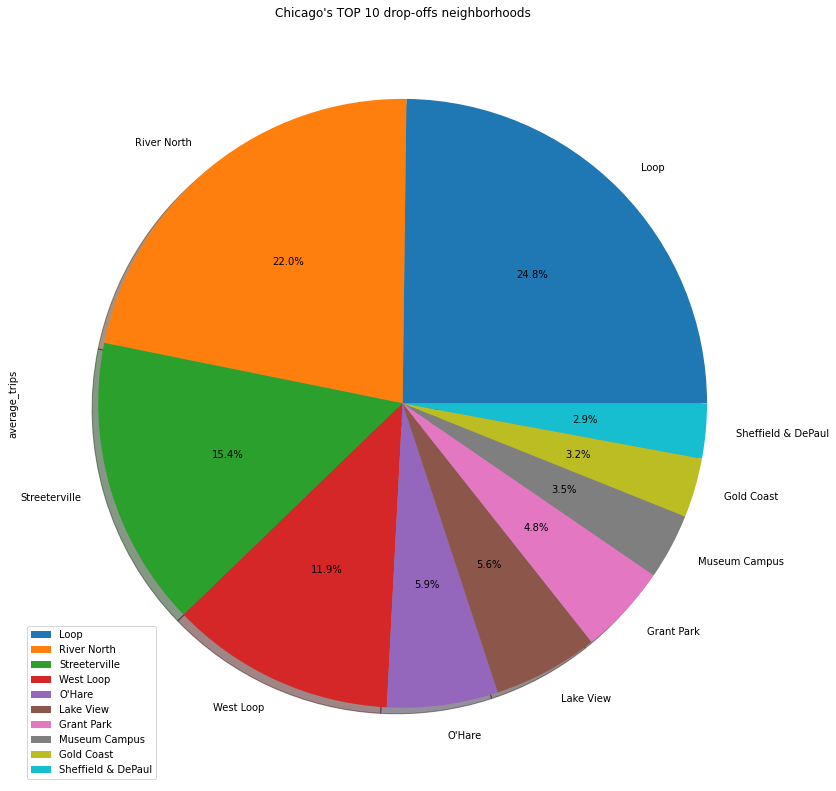

In [11]:
(top_10_dropoff_neighborhoods.set_index('dropoff_location_name')
                .plot(y='average_trips', kind='pie', 
                      title = "Chicago's TOP 10 drop-offs neighborhoods", 
                      figsize=(14, 14), autopct='%1.1f%%', shadow=True)
);

**75% of the drop-offs from top 10 neighborhoods belong to 4 neighborhoods: Loop, River North, Streeterville and West Loop. Loop has the largest amount of drop-offs with quarter of the total drop-offs from the top 10 neighborhoods, same as the other 6 neighborhoods together.**

* **Taxi companies and number of rides:**

In [12]:
len(df_trips.query('trips_amount > 1486'))

20

We'll take the top 20 companies, and the rest will be categorized as 'Other'. 

In [13]:
df_trips['name'] = np.where(df_trips['trips_amount'] > 1486, df_trips['company_name'], 'Other')

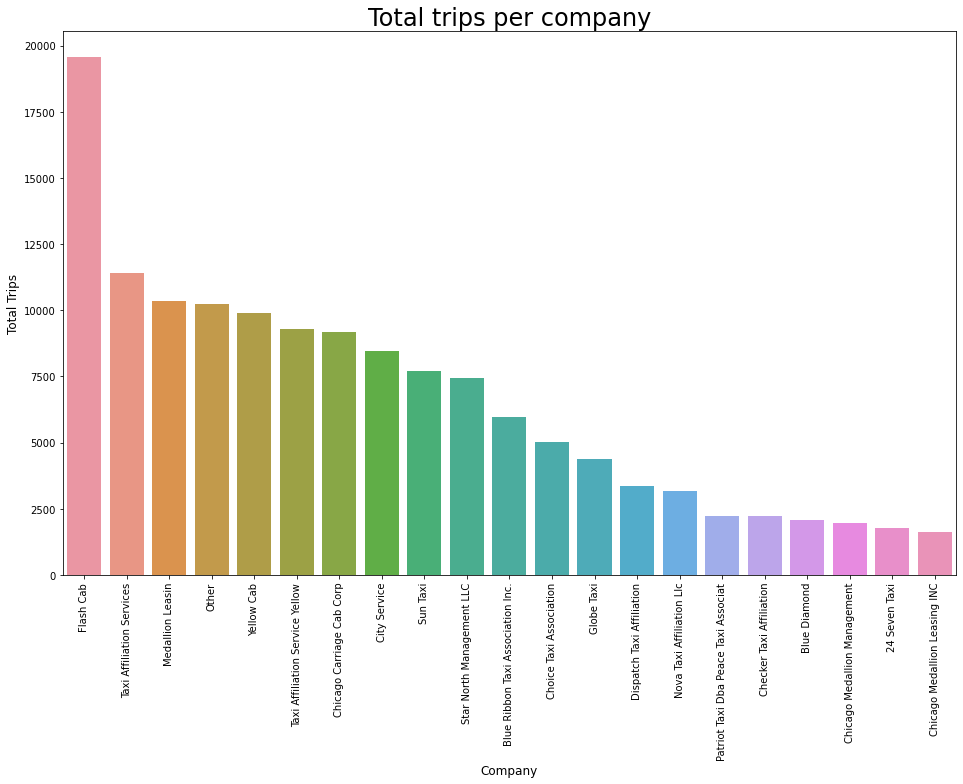

In [14]:
plt.figure(figsize=(16,10))
companies_plot = df_trips.pivot_table(index = "name", values = "trips_amount", aggfunc="sum").sort_values('trips_amount', ascending=False) 
sns.barplot(x=companies_plot.index,y="trips_amount",data = companies_plot)
plt.title('Total trips per company', size=24)
plt.xlabel('Company', size=12);
plt.ylabel('Total Trips', size=12);
plt.xticks(rotation=90)
plt.show()

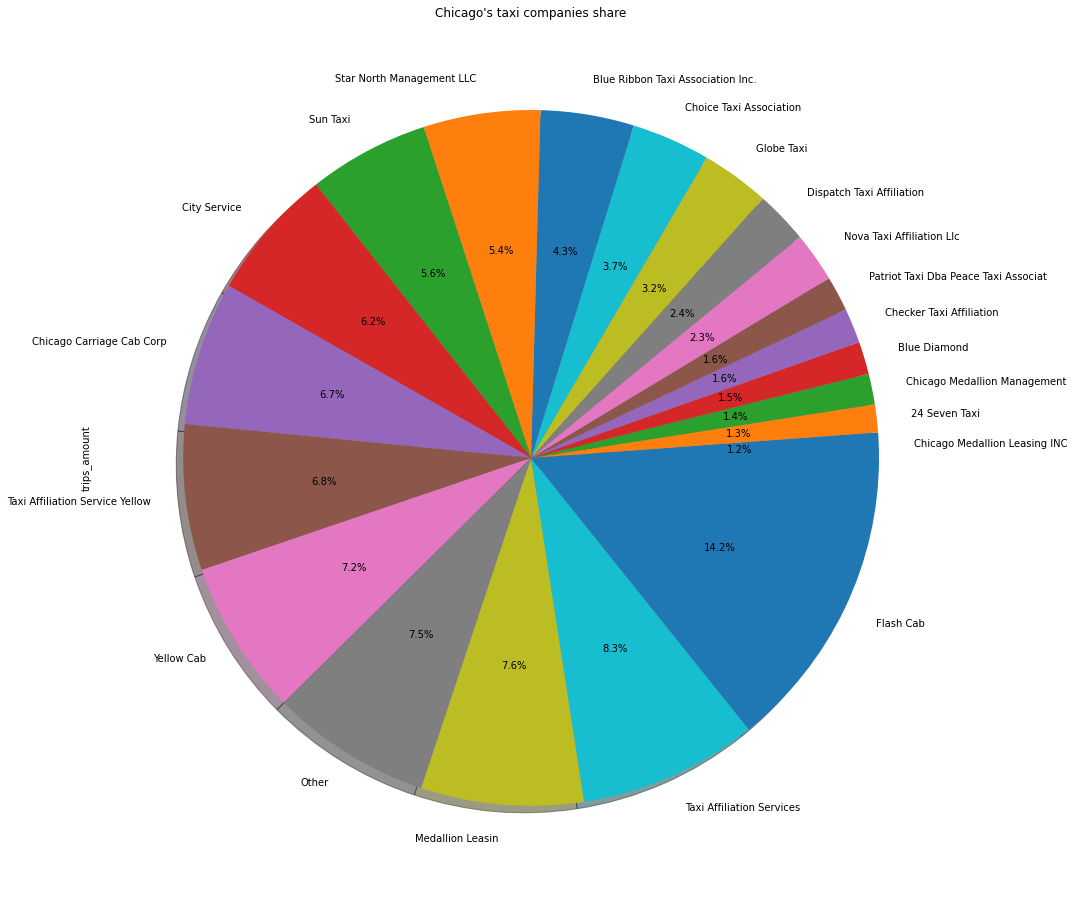

In [15]:
trips_pie = df_trips[['name', 'trips_amount']].groupby('name').sum().sort_values(by = 'trips_amount', ascending = True)
(trips_pie.plot(y='trips_amount', kind='pie', 
                      title = "Chicago's taxi companies share", 
                      figsize=(16, 16), autopct='%1.1f%%', shadow=True, legend=False)
);

**The most popular Taxi company is Flash Cab, with 14.2% of the total trips, almost double the amount of the 2nd most popular company, Taxi Affiliation Services. The top 20 companies made 92.5% of the trips, while the rest of the companies, 44 in total, made just 7.5% together.**

### 4.  Test the hypotheses:

* **The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays**

In [16]:
df_weather.sample(5)

,start_ts,weather_conditions,duration_seconds
91,2017-11-04 14:00:00,Good,3300.0
1030,2017-11-11 10:00:00,Good,1385.0
95,2017-11-04 10:00:00,Good,2551.0
508,2017-11-11 16:00:00,Good,2560.0
147,2017-11-04 16:00:00,Bad,3180.0


**H0**: The average duration of a trip with "Good" 'weather_conditions' is the same as the average duration of a trip with "Bad" 'weather_conditions'. (The means of two statistical populations are equal).

**H1**: The average duration of a trip with "Good" 'weather_conditions' is not the same as the average duration of a trip with "Bad" 'weather_conditions' (The means of two statistical populations are not equal).

We'll use the typical significance level (or alpha) of 0.05, which means that only in 5% of the case will we reject the null hypothesis when it is true.
We'll test if the populations have equal variances:

In [17]:
good = df_weather.query('weather_conditions=="Good"').dropna()['duration_seconds']
bad = df_weather.query('weather_conditions=="Bad"').dropna()['duration_seconds']


alpha = .05 
result = st.levene(good, bad)
print('p-value (levene test): {:.4f}'.format(result.pvalue))

if (result.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We retain the null hypothesis")

p-value (levene test): 0.5332
We retain the null hypothesis


The populations have equal variances. Hence we will set the equal_var parameter to True.

In [18]:
alpha = .05 
results = st.ttest_ind(good, bad, equal_var=True)

print('p-value: {:.4f}'.format(results.pvalue))


if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We retain the null hypothesis")

p-value: 0.0000
We reject the null hypothesis


**We have evidence to support the claim that the average duration of a trip with "Good" 'weather_conditions' and the average duration of a trip with "Bad" 'weather_conditions' differs.**

### 5. Overall conclusion

**The main goal was to identify patterns in the available information about passenger preferences and the impact of external factors on rides.**
First of all, I opened the files and studied the general information. 
Next step was to **prepare the data and make necessary calculations** so I could analyze it:

* Filled missing values in 6 columns.
* Made sure there are no duplicates or missing values.


Then I carried out **Exploratory Data Analysis**:
* 75% of the drop-offs from top 10 neighborhoods belong to 4 neighborhoods: Loop, River North, Streeterville and West Loop. Loop has the largest amount of drop-offs with quarter of the total drop-offs from the top 10 neighborhoods, same as the other 6 neighborhoods together.

* The most popular Taxi company is Flash Cab, with 14.2% of the total trips, almost double the amount of the 2nd most popular company, Taxi Affiliation Services. The top 20 companies made 92.5% of the trips, while the rest of the companies, 44 in total, made just 7.5% together.

I **tested the hypotheses** and found:
* The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

To finish our conclusions part, here are my recommendations for the client:
* Invest in Taxi rides to 4 neighborhoods that are most in demand for Taxi services: Loop, River North, Streeterville and West Loop.
* Weather can affect customers decisions and need for Taxi service, do the necessary adjustments. 
